***Li, if you see this, please DO NOT directly copy our codes into your Milestone II project, especially for this BERT notebook. You are welcome to reference them, but we would like to eliminate any unnecessary accusations on plagiarism.***

<br>

***Please DO run this notebook on Google Colab (Pro preferred)***.


In [1]:
# Please download tf-models-official if it wasn't installed
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 849kB 16.7MB/s 
     |████████████████████████████████| 37.6MB 1.4MB/s 
     |████████████████████████████████| 1.2MB 50.8MB/s 
     |████████████████████████████████| 706kB 48.4MB/s 
     |████████████████████████████████| 174kB 56.0MB/s 
     |████████████████████████████████| 358kB 49.9MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import json
import pickle
import tensorflow as tf
from official import nlp
from official.nlp import bert
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

import official.nlp.bert.tokenization
import official.nlp.bert.configs
import official.nlp.bert.bert_models
import official.nlp.optimization

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4G0SSHl_FcM-nnrqq42Zxa67Lvn3xX1T6AqQBcCLLUcUhz0CyE0Pw
Mounted at /content/gdrive


In [4]:
root_dir = 'gdrive/Shareddrives/MADS-Capstone-haizhou/assets/'
df_train = pd.read_csv(root_dir + 'df_train.csv')
df_dev = pd.read_csv(root_dir + 'df_dev.csv')
df_test = pd.read_csv(root_dir + 'df_test.csv')
X_train = np.array(df_train.tweet_text)
X_validate = np.array(df_dev.tweet_text)
X_test = np.array(df_test.tweet_text)
unique_labels = df_train['class_label'].unique()
dict_label = dict(zip(unique_labels,np.arange(len(unique_labels))))
y_train = np.array(df_train['class_label'].map(dict_label))
y_validate = np.array(df_dev['class_label'].map(dict_label))
y_test = np.array(df_test['class_label'].map(dict_label))

In [5]:
# This is the link to the pretrained BERT model stored on Google Cloud storage.
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

In [6]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),do_lower_case=True)

In [7]:
# Define the encode_sentence function:
# (1) Take in a sentence; (2) Tokenize into list of tokens;
# (3) Add a '[SEP]' token to the end; (4) Convert tokens to IDs.
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

# Apply this function to the training set. Note that we also included 
# input masks and input types, which are standard inputs to the BERT model.
sentence_train = tf.ragged.constant([encode_sentence(s) for s in X_train])
cls_train = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence_train.shape[0]
input_word_ids_train = tf.concat([cls_train, sentence_train], axis=-1)
input_mask_train = tf.ones_like(input_word_ids_train).to_tensor()
type_cls_train = tf.zeros_like(cls_train)
type_s1_train = tf.zeros_like(sentence_train)
input_type_ids_train = tf.concat([type_cls_train, type_s1_train], axis=-1).to_tensor()

# Do the same thing for the validation set.
sentence_validate = tf.ragged.constant([encode_sentence(s) for s in X_validate])
cls_validate = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence_validate.shape[0]
input_word_ids_validate = tf.concat([cls_validate, sentence_validate], axis=-1)
input_mask_validate = tf.ones_like(input_word_ids_validate).to_tensor()
type_cls_validate = tf.zeros_like(cls_validate)
type_s1_validate = tf.zeros_like(sentence_validate)
input_type_ids_validate = tf.concat([type_cls_validate, type_s1_validate], axis=-1).to_tensor()

In [ ]:
# Pack up the inputs for the training set and the validation set.
training_set_inputs = {
      'input_word_ids': input_word_ids_train.to_tensor(),
      'input_mask': input_mask_train,
      'input_type_ids': input_type_ids_train}

validation_set_inputs = {
      'input_word_ids': input_word_ids_validate.to_tensor(),
      'input_mask': input_mask_validate,
      'input_type_ids': input_type_ids_validate}

In [ ]:
# Also convert the training/validation set labels to tensors.
training_set_labels = tf.convert_to_tensor(y_train)
validation_set_labels = tf.convert_to_tensor(y_validate)

In [ ]:
# Download the configuration for the BERT model.
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

# Initialize the bert classifier and bert transformer encoder.
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=len(unique_labels))

In [ ]:
# Restore encoder weights
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(os.path.join(gs_folder_bert,'bert_model.ckpt')).assert_consumed()

In [12]:
# Set up epochs and steps
epochs = 2
batch_size = 25
eval_batch_size = 25

train_data_size = len(training_set_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

# Use accuracy as metric and sparse categorical cross entropy as loss.
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [ ]:
# topic_dict = {'other_relevant_information' : ['irma', 'flood', 'irma', 'victim', 'climat', 'reason', 'aftershock', 'trump', 'hurricaneharvei', 'irma relief', 'dorian'],
# 'displaced_people_and_evacuations' : ['evacu', 'evacue', 'displac', 'shelter', 'flee', 'homeless', 'mandatori', 'resid', 'order', 'million', 'peopl'],
# 'rescue_volunteering_or_donation_effort' : ['donat', 'rescu', 'volunt', 'relief', 'rescuer', 'help', 'aid', 'fundrais', 'rais', 'deliv'],
# 'caution_and_advice' : ['warn', 'emerg', 'tip', 'tornado', 'danger', 'prepar', 'flood', 'edt', 'hurricaneflor', 'declar'],
# 'sympathy_and_support' : ['prai', 'prayer', 'thought', 'heart', 'support', 'allah', 'help', 'condol', 'safe', 'hope'],
# 'infrastructure_and_utility_damage' : ['damag', 'destroi', 'destruct', 'collaps', 'power', 'build', 'home', 'hous', 'road', 'tree'],
# 'not_humanitarian' : ['trump', 'realdonaldtrump', 'job', 'instead', 'blame', 'fuck', 'kill', 'vote', 'tax', 'nebraska'],
# 'requests_or_urgent_needs' : ['help', 'need', 'urgent', 'donat', 'food', 'request', 'medicin', 'emerg', 'requir', 'desper'],
# 'injured_or_dead_or_missing_or_found_people' : ['death', 'dead', 'kill', 'injur', 'peopl','di', 'bodi','miss', 'california', 'search', 'wildfir','toll', 'hundr', 'number'],
# 'disaster_type':['cyclon', 'puertorico', 'hurrican', 'keralaflood', 'mozambiqu', 'irma', 'houston', 'hurricanedorian', 'edt', 'bahama', 'hurricaneflor', 'prayforitali', 'fire', 'harvei', 'cycloneidai', 'nebraska', 'dorian', 'maria', 'matthew', 'kerala', 'italyearthquak', 'ecuador', 'hurricaneirma', 'eqnz', 'hurricanemaria', 'itali', 'wildfir', 'haiti', 'florenc', 'earthquak', 'hurricaneharvei', 'california']}

topic_dict_unstemmed = {'other_relevant_information' : ['irma', 'flood', 'victim', 'climate', 'reason', 'aftershock', 'trump', 'hurricaneharvey', 'relief', 'dorian'],
'displaced_people_and_evacuations' : ['evacuate', 'evacuee', 'displace', 'shelter', 'flee', 'homeless', 'mandatory', 'residence', 'order', 'million', 'people'],
'rescue_volunteering_or_donation_effort' : ['donate', 'rescue', 'volunteer', 'relief', 'rescuer', 'help', 'aid', 'fundraise', 'raise', 'deliver'],
'caution_and_advice' : ['warn', 'emerge', 'tip', 'tornado', 'danger', 'prepare', 'flood', 'edt', 'hurricaneflorence', 'declare'],
'sympathy_and_support' : ['pray', 'prayer', 'thought', 'heart', 'support', 'allah', 'help', 'condole', 'safe', 'hope'],
'infrastructure_and_utility_damage' : ['damage', 'destroy', 'destruct', 'collapse', 'power', 'build', 'home', 'house', 'road', 'tree'],
'not_humanitarian' : ['trump', 'realdonaldtrump', 'job', 'instead', 'blame', 'fuck', 'kill', 'vote', 'tax', 'nebraska'],
'requests_or_urgent_needs' : ['help', 'need', 'urgent', 'donate', 'food', 'request', 'medicine', 'emerge', 'require', 'desperate'],
'injured_or_dead_or_missing_or_found_people' : ['death', 'dead', 'kill', 'injure', 'people','die', 'body','miss', 'california', 'search', 'wildfire','toll', 'hundred', 'number'],
'disaster_type':['cyclone', 'puertorico', 'hurricane', 'keralaflood', 'mozambique', 'irma', 'houston', 'hurricanedorian', 'edt', 'bahama', 'hurricaneflorence', 'prayforitaly', 'fire', 'harvei', 'cycloneidai', 'nebraska', 'dorian', 'maria', 'matthew', 'kerala', 'italyearthquake', 'ecuador', 'hurricaneirma', 'eqnz', 'hurricanemaria', 'italy', 'wildfire', 'haiti', 'florence', 'earthquake', 'hurricaneharvey', 'california']}

color_dict = {'other_relevant_information' : 'red',
'displaced_people_and_evacuations' : '#CCCC00',
'rescue_volunteering_or_donation_effort' : 'orange',
'caution_and_advice' : 'green',
'sympathy_and_support' : 'blue',
'infrastructure_and_utility_damage' : 'purple',
'not_humanitarian' : '#ff1493',
'requests_or_urgent_needs' : 'brown',
'injured_or_dead_or_missing_or_found_people' : '#c68642',
'disaster_type':'black'}
color_dict_reverse = dict(zip(list(color_dict.values()),list(color_dict.keys())))

color_style = {}
for key in topic_dict_unstemmed:
  for value in topic_dict_unstemmed[key]:
    color_style[value]=color_dict[key]


In [32]:
# Employ t-SNE to measure the similarity of word embedding vectors, and meanwhile reduce the dimensionality for visualization.
word_name = list(color_style.keys())
word_id_filtered = []
word_name_filtered = []
for word in word_name:
  try:
    word_id_filtered.append(tokenizer.convert_tokens_to_ids([word])[0])
    word_name_filtered.append(word)
  except:
    continue
from sklearn.manifold import TSNE
tokens = np.zeros((len(word_name_filtered),768))
for i in range(len(word_name_filtered)):
    tokens[i,:] = bert_encoder.get_weights()[0][word_id_filtered[i],:]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
tokens_reduced = tsne_model.fit_transform(tokens)
tokens_reduced.shape

(85, 2)

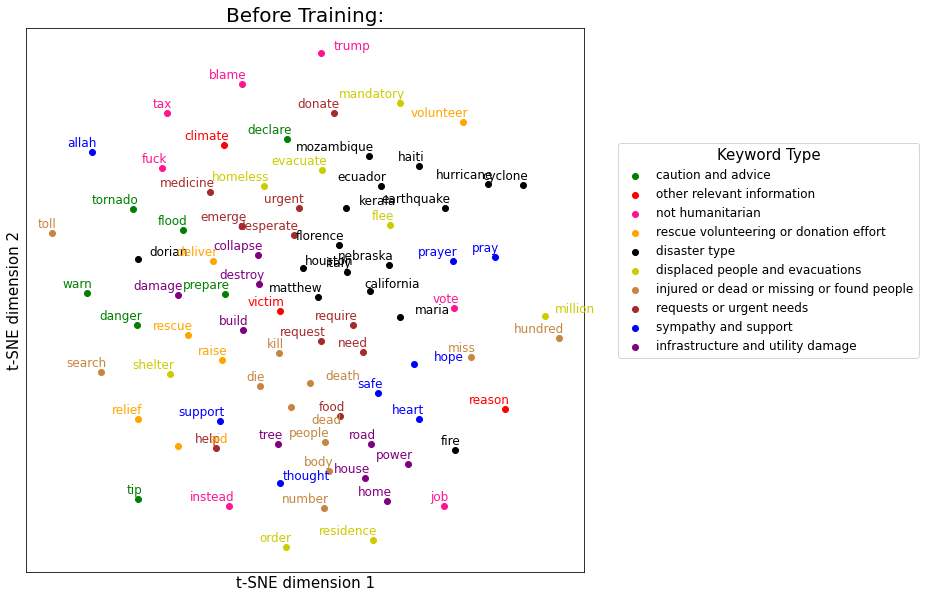

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10), linewidth=3) 
color_used = []
for i in range(tokens_reduced.shape[0]):
    if word_name_filtered[i] in color_style:
      color = color_style[word_name_filtered[i]]
    else:
      color = 'silver'
    if color not in color_used:
      color_used.append(color)
      if color is not 'silver':
        plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color,label=color_dict_reverse[color].replace('_',' '))
      else:
        plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color,label='(not a keyword)')
    else:
      plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color)
    rand = np.random.random()
    # Matplotlib does not have a smart annotation positioning module, so have to work around manually.
    if word_name_filtered[i] in ['trump','destruct','destroi','aid','hurricanemaria',
                    'dorian','kerala','volunt','california','houston','maria',
                    'keralaflood','million','death','thought','hope','emerg']:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(50, 0),textcoords='offset points',ha='right',va='bottom',fontsize=12)
    elif word_name_filtered[i] in ['hous','prai','hurricaneharvei','hurricaneirma','florenc','donat','prepar','dead']:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(50, -20),textcoords='offset points',ha='right',va='bottom',fontsize=12)      
    else:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(5, 2),textcoords='offset points',ha='right',va='bottom',fontsize=12)
plt.xlabel('t-SNE dimension 1',fontsize=15)
plt.ylabel('t-SNE dimension 2',fontsize=15)
plt.xticks([], [])
plt.yticks([], [])
plt.legend(bbox_to_anchor=(1.05, 0.8),prop={'size': 12},title='Keyword Type',title_fontsize=15)
plt.title('Before Training',fontsize=20)
plt.show()

In [37]:
root_dir = 'gdrive/Shareddrives/MADS-Capstone-haizhou/assets/BERT-checkpoints/'
bert_classifier = tf.saved_model.load(root_dir+'epoch1')

In [40]:
np.array(bert_classifier.variables[0]).shape

(30522, 768)

In [48]:
tokens = np.zeros((len(word_name_filtered),768))
for i in range(len(word_name_filtered)):
    tokens[i,:] = np.array(bert_classifier.trainable_variables[0])[word_id_filtered[i],:]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
tokens_reduced = tsne_model.fit_transform(tokens)

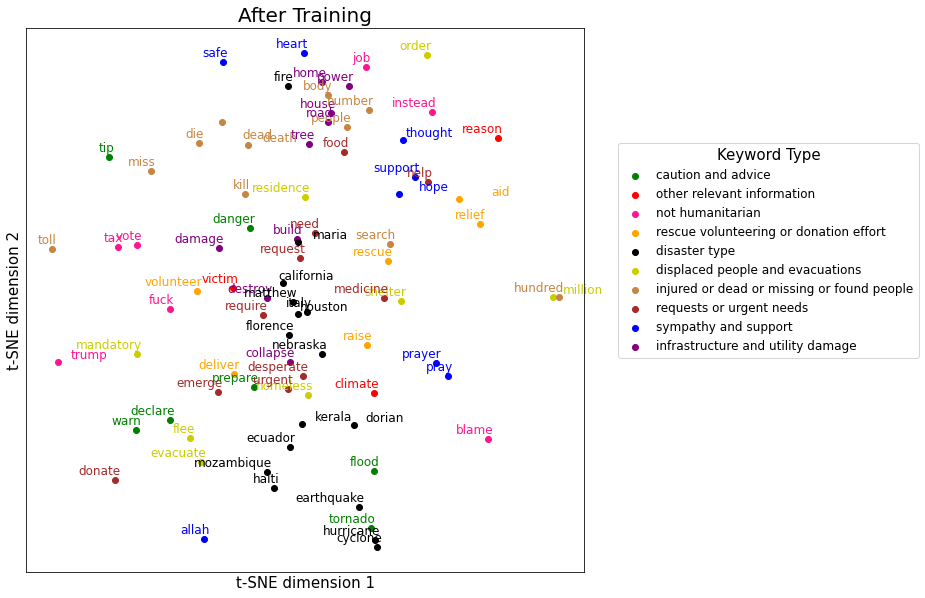

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10), linewidth=3) 
color_used = []
for i in range(tokens_reduced.shape[0]):
    if word_name_filtered[i] in color_style:
      color = color_style[word_name_filtered[i]]
    else:
      color = 'silver'
    if color not in color_used:
      color_used.append(color)
      if color is not 'silver':
        plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color,label=color_dict_reverse[color].replace('_',' '))
      else:
        plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color,label='(not a keyword)')
    else:
      plt.scatter(tokens_reduced[i][0],tokens_reduced[i][1],color=color)
    rand = np.random.random()
    # Matplotlib does not have a smart annotation positioning module, so have to work around manually.
    if word_name_filtered[i] in ['trump','destruct','destroi','aid','hurricanemaria',
                    'dorian','kerala','volunt','california','houston','maria',
                    'keralaflood','million','death','thought','hope','emerg']:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(50, 0),textcoords='offset points',ha='right',va='bottom',fontsize=12)
    elif word_name_filtered[i] in ['hous','prai','hurricaneharvei','hurricaneirma','florenc','donat','prepar','dead']:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(50, -20),textcoords='offset points',ha='right',va='bottom',fontsize=12)      
    else:
      plt.annotate(word_name_filtered[i],xy=(tokens_reduced[i][0],tokens_reduced[i][1]),color=color,
                 xytext=(5, 2),textcoords='offset points',ha='right',va='bottom',fontsize=12)
plt.xlabel('t-SNE dimension 1',fontsize=15)
plt.ylabel('t-SNE dimension 2',fontsize=15)
plt.xticks([], [])
plt.yticks([], [])
plt.legend(bbox_to_anchor=(1.05, 0.8),prop={'size': 12},title='Keyword Type',title_fontsize=15)
plt.title('After Training',fontsize=20)
plt.show()

### Surprisingly after training, the word embeddings are not so much "clustered" as before. Maybe BERT captured some patterns in sentences?